# Homework Week 1 - Lay (Lei) Yang

This code was developed by Lei Yang for DATA 512 Homework, a course in the UW MS Data Science degree program. This code develped based on the Creative Commons CC-BY license (https://creativecommons.org/). Revision 1.3 - August 16, 2024.

In [1]:
import pandas as pd
import requests
import json, time, urllib.parse
from collections import defaultdict

# Step 1: Data Acquisition

## 1.1 Load the CSV to Get Page Titles

In [2]:
# Direct download link
url = 'https://drive.google.com/uc?id=15_FiKhBgXB2Ch9c0gAGYzKjF0DBhEPlY&export=download'

# Read the CSV file from Google Drive
df = pd.read_csv(url)

# Display the first few rows of the dataframe
print(df.head())

                           disease    pageid  \
0             Klinefelter syndrome  19833554   
1           Aarskog–Scott syndrome   7966521   
2             Abetalipoproteinemia     68451   
3                            MT-TP  20945466   
4  Ablepharon macrostomia syndrome  10776100   

                                                 url  
0  https://en.wikipedia.org/wiki/Klinefelter_synd...  
1  https://en.wikipedia.org/wiki/Aarskog–Scott_sy...  
2  https://en.wikipedia.org/wiki/Abetalipoprotein...  
3                https://en.wikipedia.org/wiki/MT-TP  
4  https://en.wikipedia.org/wiki/Ablepharon_macro...  


In [3]:
# Save the article titles to a list
ARTICLE_TITLES = df['disease'].tolist()

## 1.2 Use the Wikimedia REST API for PageViews

In [5]:
# The REST API 'pageviews' URL
API_REQUEST_PAGEVIEWS_ENDPOINT = 'https://wikimedia.org/api/rest_v1/metrics/pageviews/'

# Use parameterized string that specifies what kind of pageviews request we are going to make
API_REQUEST_PER_ARTICLE_PARAMS = 'per-article/{project}/{access}/{agent}/{article}/{granularity}/{start}/{end}'

# Define start and end date
start_date = "2015010100"
end_date = "2023040100"

# Assuming roughly 2ms latency on the API and network
API_LATENCY_ASSUMED = 0.002  
API_THROTTLE_WAIT = (1.0/100.0) - API_LATENCY_ASSUMED

# When making a request to the Wikimedia API they ask that you include your email address which will allow them
# to contact you if something happens - such as - your code exceeding rate limits - or some other error 
REQUEST_HEADERS = {
    'User-Agent': '<layyang@uw.edu>, University of Washington, MSDS DATA 512 - AUTUMN 2023',
}

# Pageview template
ARTICLE_PAGEVIEWS_PARAMS_TEMPLATE = {
    "project":     "en.wikipedia.org",
    "agent":       "user",
    "article":     "",
    "granularity": "monthly",
    "start":       start_date,
    "end":         end_date
}

## 1.3 Fetching Page Views for Multiple Articles

Define function to request desktop pageviews for a given article

In [6]:
def request_pageviews_per_article(article_title=None, access='desktop', endpoint_url=API_REQUEST_PAGEVIEWS_ENDPOINT, endpoint_params=API_REQUEST_PER_ARTICLE_PARAMS, request_template=ARTICLE_PAGEVIEWS_PARAMS_TEMPLATE, headers=REQUEST_HEADERS):
    if article_title:
        request_template['article'] = article_title

    if not request_template['article']:
        raise Exception("Must supply an article title to make a pageviews request.")

    request_template['access'] = access
    article_title_encoded = urllib.parse.quote(request_template['article'].replace(' ', '_'))
    request_template['article'] = article_title_encoded

    request_url = endpoint_url + endpoint_params.format(**request_template)

    try:
        if API_THROTTLE_WAIT > 0.0:
            time.sleep(API_THROTTLE_WAIT)
        response = requests.get(request_url, headers=headers)
        json_response = response.json()
    except Exception as e:
        print(e)
        json_response = None
    return json_response

Define function to request mobile-web & mobile-app pageviews for a given article

In [7]:
def aggregate_mobile_pageviews(article_title):
    mobile_web_views = request_pageviews_per_article(article_title, access='mobile-web')
    mobile_app_views = request_pageviews_per_article(article_title, access='mobile-app')

    if not mobile_web_views or not mobile_app_views:
        return None

    mobile_pageviews = defaultdict(int)
    for item in mobile_web_views.get('items', []):
        month = item['timestamp'][:6]  # Get YYYYMM
        mobile_pageviews[month] += item['views']

    for item in mobile_app_views.get('items', []):
        month = item['timestamp'][:6]
        mobile_pageviews[month] += item['views']

    return dict(mobile_pageviews)

Define function to request Monthly cumulative pageviews for a given article

In [8]:
def aggregate_desktop_pageviews(article_title):
    desktop_views = request_pageviews_per_article(article_title, access='desktop')

    if not desktop_views:
        return None

    desktop_pageviews = {}
    for item in desktop_views.get('items', []):
        month = item['timestamp'][:6]  # Get YYYYMM
        desktop_pageviews[month] = item['views']

    return desktop_pageviews

In [9]:
def merge_pageviews(mobile_pageviews, desktop_pageviews):
    cumulative_pageviews = defaultdict(int)

    # Add desktop views
    for month, views in desktop_pageviews.items():
        cumulative_pageviews[month] += views

    # Add mobile views
    for month, views in mobile_pageviews.items():
        cumulative_pageviews[month] += views

    return dict(cumulative_pageviews)


# 2. Prepare File Exproting

## 2.1 Create the file names

In [10]:
# Create the file names based on start and end dates
start_yyyymm = start_date[:6]
end_yyyymm = end_date[:6]

mobile_filename = f"rare-disease_monthly_mobile_{start_yyyymm}-{end_yyyymm}.json"
desktop_filename = f"rare-disease_monthly_desktop_{start_yyyymm}-{end_yyyymm}.json"
cumulative_filename = f"rare-disease_monthly_cumulative_{start_yyyymm}-{end_yyyymm}.json"


## 2.2 Collect page view data and save in dictionaries

In [11]:
# Dictionaries to hold data for all articles
all_mobile_data = {}
all_desktop_data = {}
all_cumulative_data = {}

# Loop through each article and collect page view data
for article_title in ARTICLE_TITLES:
    print(f"Fetching data for: {article_title}")

    # Fetch mobile pageviews (mobile-web + mobile-app)
    mobile_pageviews = aggregate_mobile_pageviews(article_title)
    if mobile_pageviews:
        all_mobile_data[article_title] = mobile_pageviews

    # Fetch desktop pageviews
    desktop_pageviews = aggregate_desktop_pageviews(article_title)
    if desktop_pageviews:
        all_desktop_data[article_title] = desktop_pageviews

    # Merge desktop and mobile pageviews to get cumulative data
    if mobile_pageviews and desktop_pageviews:
        cumulative_pageviews = merge_pageviews(mobile_pageviews, desktop_pageviews)
        all_cumulative_data[article_title] = cumulative_pageviews

Fetching data for: Klinefelter syndrome
Fetching data for: Aarskog–Scott syndrome
Fetching data for: Abetalipoproteinemia
Fetching data for: MT-TP
Fetching data for: Ablepharon macrostomia syndrome
Fetching data for: Acanthocheilonemiasis
Fetching data for: Acanthosis nigricans
Fetching data for: Aceruloplasminemia
Fetching data for: Megaesophagus
Fetching data for: Achard–Thiers syndrome
Fetching data for: Achondrogenesis
Fetching data for: Achondroplasia
Fetching data for: Dwarfism
Fetching data for: Osteochondrodysplasia
Fetching data for: Fibroblast growth factor receptor 3
Fetching data for: Vestibular schwannoma
Fetching data for: Brain tumor
Fetching data for: Acquired generalized lipodystrophy
Fetching data for: Barraquer–Simons syndrome
Fetching data for: Acrodermatitis enteropathica
Fetching data for: Zinc deficiency
Fetching data for: Brown-Séquard syndrome
Fetching data for: Spinal cord injury
Fetching data for: Brucellosis
Fetching data for: Yellowstone Park bison herd
Fet

Fetching data for: Cor triatriatum
Fetching data for: Epithelial basement membrane dystrophy
Fetching data for: Macular corneal dystrophy
Fetching data for: Meesmann corneal dystrophy
Fetching data for: Schnyder crystalline corneal dystrophy
Fetching data for: Posterior polymorphous corneal dystrophy
Fetching data for: Cornelia de Lange syndrome
Fetching data for: SMC1A
Fetching data for: Establishment of sister chromatid cohesion
Fetching data for: SMC3
Fetching data for: CDLS
Fetching data for: Corticobasal degeneration
Fetching data for: Costello syndrome
Fetching data for: HRAS
Fetching data for: Craniofrontonasal dysplasia
Fetching data for: Craniometaphyseal dysplasia
Fetching data for: Craniopharyngioma
Fetching data for: Creatine transporter defect
Fetching data for: Creutzfeldt–Jakob disease
Fetching data for: Mepacrine
Fetching data for: Cri du chat syndrome
Fetching data for: Crigler–Najjar syndrome
Fetching data for: Cronkhite–Canada syndrome
Fetching data for: Crouzon synd

Fetching data for: Long-term effects of alcohol
Fetching data for: Electrophysiological techniques for clinical diagnosis
Fetching data for: Discovery and development of beta-blockers
Fetching data for: Evans syndrome
Fetching data for: Ewing's sarcoma
Fetching data for: Ewing family of tumors
Fetching data for: Mir-708 microRNA precursor family
Fetching data for: Fabry disease
Fetching data for: Alpha-galactosidase
Fetching data for: Facioscapulohumeral muscular dystrophy
Fetching data for: Trapezius
Fetching data for: Factor VII deficiency
Fetching data for: Factor X deficiency
Fetching data for: Haemophilia C
Fetching data for: Factor XII deficiency
Fetching data for: Factor XIII deficiency
Fetching data for: Familial adenomatous polyposis
Fetching data for: Colorectal polyp
Fetching data for: Celecoxib
Fetching data for: Cancer syndrome
Fetching data for: Benign tumor
Fetching data for: Rectal discharge
Fetching data for: Mouse model of colorectal and intestinal cancer
Fetching dat

Fetching data for: Hereditary leiomyomatosis and renal cell carcinoma
Fetching data for: Hereditary multiple exostoses
Fetching data for: Exostosis
Fetching data for: Hereditary neuralgic amyotrophy
Fetching data for: Congenital insensitivity to pain with anhidrosis
Fetching data for: Familial dysautonomia
Fetching data for: Adult polyglucosan body disease
Fetching data for: Hereditary diffuse leukoencephalopathy with spheroids
Fetching data for: Adult-onset Still's disease
Fetching data for: Hay–Wells syndrome
Fetching data for: Rapp–Hodgkin syndrome
Fetching data for: Hypogammaglobulinemia
Fetching data for: Corpus callosum
Fetching data for: Agenesis
Fetching data for: Spatial hearing loss
Fetching data for: Neutropenia
Fetching data for: Aicardi syndrome
Fetching data for: AIDS dysmorphic syndrome
Fetching data for: Alagille syndrome
Fetching data for: Alexander disease
Fetching data for: Alkaptonuria
Fetching data for: Allelic heterogeneity
Fetching data for: Alopecia areata
Fetch

Fetching data for: Uric acid
Fetching data for: J. Edwin Seegmiller
Fetching data for: Leukodystrophy
Fetching data for: Li–Fraumeni syndrome
Fetching data for: Lichen planus
Fetching data for: Lichen sclerosus
Fetching data for: Liposarcoma
Fetching data for: Eribulin
Fetching data for: Lipoblast
Fetching data for: Lissencephaly
Fetching data for: Gyrification
Fetching data for: Neurotubule
Fetching data for: Development of the cerebral cortex
Fetching data for: Reelin
Fetching data for: Listeriosis
Fetching data for: Locked-in syndrome
Fetching data for: Disorders of consciousness
Fetching data for: Central nervous system disease
Fetching data for: Long QT syndrome
Fetching data for: Romano–Ward syndrome
Fetching data for: Oculocerebrorenal syndrome
Fetching data for: Lymphangioleiomyomatosis
Fetching data for: Cystic hygroma
Fetching data for: Microcystic lymphatic malformation
Fetching data for: Lymphangioma
Fetching data for: Lymphangioma circumscriptum
Fetching data for: Lymphang

Fetching data for: Euphoria
Fetching data for: Otilimab
Fetching data for: Dopamine
Fetching data for: Paced Auditory Serial Addition Test
Fetching data for: Histamine
Fetching data for: Wayne Dobson
Fetching data for: IL2RA
Fetching data for: Susan Kennedy
Fetching data for: Neurogenic bowel dysfunction
Fetching data for: Neuroinflammation
Fetching data for: Perivascular space
Fetching data for: HLA-DQB1
Fetching data for: Multiple sulfatase deficiency
Fetching data for: Multiple system atrophy
Fetching data for: Substantia nigra
Fetching data for: Susana Schnarndorf
Fetching data for: Mumps
Fetching data for: MUMPS
Fetching data for: Parotid gland
Fetching data for: Breakthrough infection
Fetching data for: Parotitis
Fetching data for: Syncytium
Fetching data for: Undefined variable
Fetching data for: Myasthenia gravis
Fetching data for: Thymus
Fetching data for: Neuromuscular junction disease
Fetching data for: Acetylcholine
Fetching data for: Mycosis fungoides
Fetching data for: Lu

Fetching data for: Pediatric gynaecology
Fetching data for: Primary biliary cholangitis
Fetching data for: Ursodeoxycholic acid
Fetching data for: Obeticholic acid
Fetching data for: Rifampicin
Fetching data for: Primary central nervous system lymphoma
Fetching data for: Mir-19 microRNA precursor family
Fetching data for: Primary ciliary dyskinesia
Fetching data for: Primary anemia
Fetching data for: Anencephaly
Fetching data for: Angelman syndrome
Fetching data for: GABRB3
Fetching data for: Artificial transcription factor
Fetching data for: Angioimmunoblastic T-cell lymphoma
Fetching data for: Aniridia
Fetching data for: Eye color
Fetching data for: Corneal limbus
Fetching data for: Gillespie syndrome
Fetching data for: Anthrax
Fetching data for: Louis Pasteur
Fetching data for: Robert Koch
Fetching data for: Dave Sabo
Fetching data for: Biomedical Advanced Research and Development Authority
Fetching data for: Antiphospholipid syndrome
Fetching data for: Cardiolipin
Fetching data for

Fetching data for: Poxviridae
Fetching data for: Native American disease and epidemics
Fetching data for: First Fleet
Fetching data for: Alastrim
Fetching data for: Smith–Magenis syndrome
Fetching data for: Chromosome 17
Fetching data for: Smith–Lemli–Opitz syndrome
Fetching data for: Sneddon's syndrome
Fetching data for: Snyder–Robinson syndrome
Fetching data for: Soft-tissue sarcoma
Fetching data for: Nanobiotix
Fetching data for: Trabectedin
Fetching data for: Evofosfamide
Fetching data for: Sotos syndrome
Fetching data for: Spina bifida
Fetching data for: Tethered spinal cord syndrome
Fetching data for: Congenital vertebral anomaly
Fetching data for: Latex allergy
Fetching data for: Bianca Jackson
Fetching data for: Spinal disease
Fetching data for: Project Nicaragua
Fetching data for: MTRR (gene)
Fetching data for: Spinal muscular atrophy
Fetching data for: SR protein
Fetching data for: Wendy Chung
Fetching data for: KHDRBS1
Fetching data for: Distal spinal muscular atrophy type 1

Fetching data for: Warm antibody autoimmune hemolytic anemia
Fetching data for: Weaver syndrome
Fetching data for: EZH2
Fetching data for: Weill–Marchesani syndrome
Fetching data for: Weismann-Netter–Stuhl syndrome
Fetching data for: Werner syndrome
Fetching data for: Cruciform DNA
Fetching data for: Wernicke–Korsakoff syndrome
Fetching data for: Brain damage
Fetching data for: West Nile fever
Fetching data for: West Nile virus
Fetching data for: Japanese encephalitis
Fetching data for: Viral encephalitis
Fetching data for: American crow
Fetching data for: Eastern equine encephalitis
Fetching data for: Epileptic spasms
Fetching data for: WHIM syndrome
Fetching data for: Wieacker syndrome
Fetching data for: Wiedemann–Rautenstrauch syndrome
Fetching data for: Wildervanck syndrome
Fetching data for: Williams syndrome
Fetching data for: Cytochrome P450 reductase
Fetching data for: Central sulcus
Fetching data for: Wilms' tumor
Fetching data for: Sidney Farber
Fetching data for: Winchester 

## 2.3 Export to JSON files

In [12]:
# Write the results to JSON files
with open(mobile_filename, 'w') as f:
    json.dump(all_mobile_data, f, indent=4)
    print(f"Mobile data written to {mobile_filename}")

with open(desktop_filename, 'w') as f:
    json.dump(all_desktop_data, f, indent=4)
    print(f"Desktop data written to {desktop_filename}")

with open(cumulative_filename, 'w') as f:
    json.dump(all_cumulative_data, f, indent=4)
    print(f"Cumulative data written to {cumulative_filename}")

Mobile data written to rare-disease_monthly_mobile_201501-202304.json
Desktop data written to rare-disease_monthly_desktop_201501-202304.json
Cumulative data written to rare-disease_monthly_cumulative_201501-202304.json


# Step 2: Analysis

Import and load JSON files

In [13]:
import matplotlib.pyplot as plt

In [16]:
# Load the JSON files for desktop and mobile data
with open("rare-disease_monthly_mobile_201501-202304.json", "r") as f:
    mobile_data = json.load(f)

with open("rare-disease_monthly_desktop_201501-202304.json", "r") as f:
    desktop_data = json.load(f)

## 2.1 Convert JSON data into DataFrame

In [17]:
# Helper function to convert JSON data into pandas DataFrame
def json_to_dataframe(data):
    # Check if data is a dictionary with time-series data
    if isinstance(data, dict):
        df = pd.DataFrame.from_dict(data, orient='index')
        df.index = pd.to_datetime(df.index, format='%Y%m')
        df.fillna(0, inplace=True)
        return df
    else:
        # If data is not in expected format, return an empty DataFrame
        return pd.DataFrame()

In [18]:
# Convert mobile and desktop data into DataFrames, ensuring the data is valid
mobile_df_dict = {k: json_to_dataframe(v) for k, v in mobile_data.items() if isinstance(v, dict)}
desktop_df_dict = {k: json_to_dataframe(v) for k, v in desktop_data.items() if isinstance(v, dict)}

In [20]:
# Create combined DataFrames for mobile and desktop data
mobile_df = pd.concat(mobile_df_dict, axis=1)
desktop_df = pd.concat(desktop_df_dict, axis=1)

# Fill missing values (if any) with zeros
mobile_df.fillna(0, inplace=True)
desktop_df.fillna(0, inplace=True)

## 2.2 Conduct Calculation

In [21]:
# Calculate the average page views per article for mobile and desktop
mobile_avg = mobile_df.mean(axis=0)
desktop_avg = desktop_df.mean(axis=0)

### 2.2.1 Maximum Average and Minimum Average

The first graph contain time series for the articles that have the highest average page requests and the lowest average page requests for desktop access and mobile access over the entire time series. 

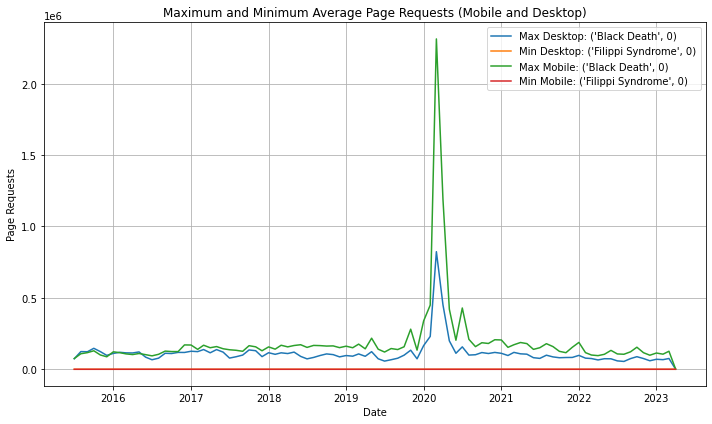

In [22]:
# 1. Maximum Average and Minimum Average Graph
# Find max and min for both mobile and desktop
max_mobile = mobile_avg.idxmax()
min_mobile = mobile_avg.idxmin()
max_desktop = desktop_avg.idxmax()
min_desktop = desktop_avg.idxmin()

plt.figure(figsize=(10, 6))

# Plot max and min for desktop
plt.plot(desktop_df[max_desktop], label=f"Max Desktop: {max_desktop}")
plt.plot(desktop_df[min_desktop], label=f"Min Desktop: {min_desktop}")

# Plot max and min for mobile
plt.plot(mobile_df[max_mobile], label=f"Max Mobile: {max_mobile}")
plt.plot(mobile_df[min_mobile], label=f"Min Mobile: {min_mobile}")

plt.title("Maximum and Minimum Average Page Requests (Mobile and Desktop)")
plt.xlabel("Date")
plt.ylabel("Page Requests")
plt.legend(loc="upper right")
plt.grid(True)
plt.tight_layout()

# Save the figure
plt.savefig("max_min_average_page_requests.png")
plt.show()

### 2.2.2 Top 10 Peak Page Views

The second graph contains time series for the top 10 article pages by largest (peak) page views over the entire time series by access type. It shows the month for each article that contains the highest (peak) page views, and then order the articles by these peak values. 

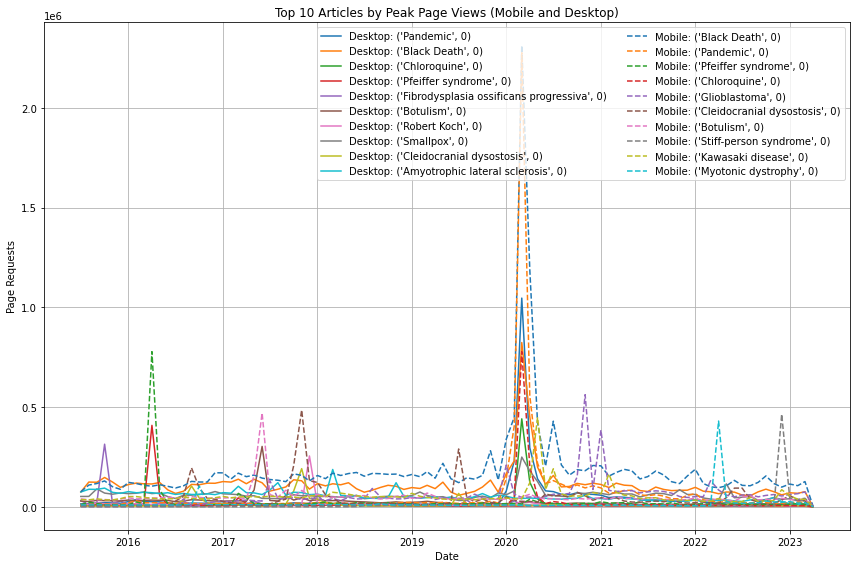

In [23]:
# 2. Top 10 Peak Page Views
# Find the peak value for each article
mobile_peak = mobile_df.max().sort_values(ascending=False).head(10)
desktop_peak = desktop_df.max().sort_values(ascending=False).head(10)

plt.figure(figsize=(12, 8))

# Plot top 10 articles for desktop and mobile
for article in desktop_peak.index:
    plt.plot(desktop_df[article], label=f"Desktop: {article}")

for article in mobile_peak.index:
    plt.plot(mobile_df[article], label=f"Mobile: {article}", linestyle='--')

plt.title("Top 10 Articles by Peak Page Views (Mobile and Desktop)")
plt.xlabel("Date")
plt.ylabel("Page Requests")
plt.legend(loc="upper right", ncol=2)
plt.grid(True)
plt.tight_layout()

# Save the figure
plt.savefig("top_10_peak_page_views.png")
plt.show()

### 2.2.3 Fewest Months of Data

The third graph shows pages that have the fewest months of available data. These will likely be relatively short time series, some may only have one month of data. This graph shows the 10 articles with the fewest months of data for desktop access and the 10 articles with the fewest months of data for mobile access.

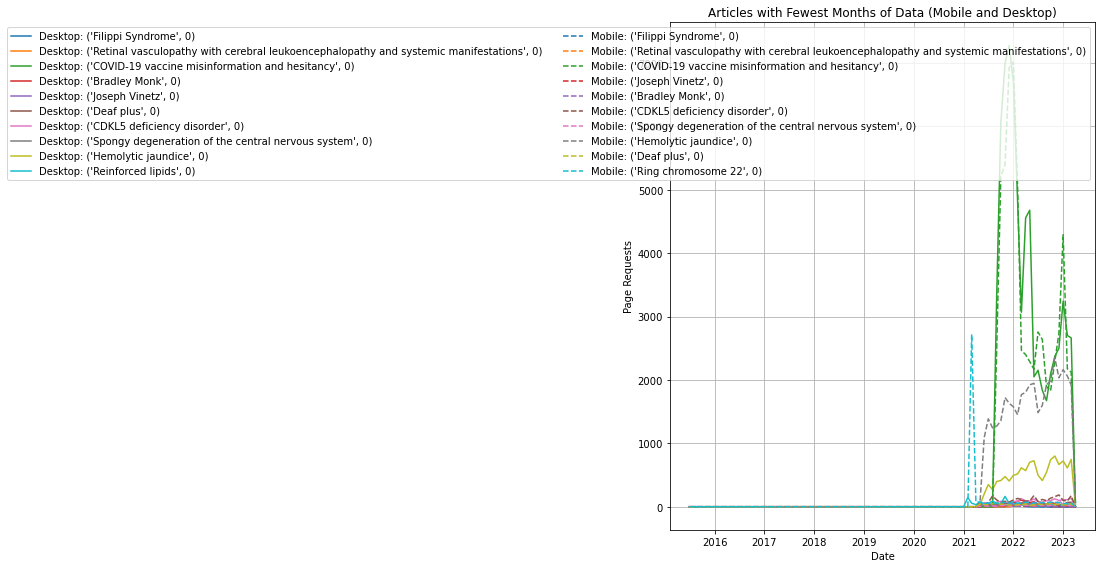

In [24]:
# 3. Fewest Months of Data
# Find the articles with the fewest non-zero months of data
mobile_month_count = (mobile_df > 0).sum().sort_values().head(10)
desktop_month_count = (desktop_df > 0).sum().sort_values().head(10)

plt.figure(figsize=(12, 8))

# Plot fewest months of data for desktop and mobile
for article in desktop_month_count.index:
    plt.plot(desktop_df[article], label=f"Desktop: {article}")

for article in mobile_month_count.index:
    plt.plot(mobile_df[article], label=f"Mobile: {article}", linestyle='--')

plt.title("Articles with Fewest Months of Data (Mobile and Desktop)")
plt.xlabel("Date")
plt.ylabel("Page Requests")
plt.legend(loc="upper right", ncol=2)
plt.grid(True)
plt.tight_layout()

# Save the figure
plt.savefig("fewest_months_of_data.png")
plt.show()